#### Session-Stopper

In [ ]:
import time
for i in range(50):
  print('Stop: ', i)
  time.sleep(30*60)

-----

In [1]:
!pip install -q pymap3d


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import random
import numpy as np
from math import atan2, asin
import pandas as pd
from IPython.display import display
from pprint import pprint
from PIL import Image
import time
import datetime
import time
import sys
from pymap3d import geodetic2enu, enu2geodetic
import warnings
warnings.filterwarnings('ignore')

image_size = (1920, 1200)
fx, fy, cx, cy = [718.8560, 718.8560, 607.1928, 185.2157]
camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

In [3]:
!unzip -q /content/optical-edge-dev.zip

------

In [4]:
!unzip -q sample-dataset-xs.zip

In [4]:
sys.path.append('/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/optical-edge-dev')
import pose_est
from pose_est import *
import vo
from vo import Stitcher
from vo import FeatureLocalization

In [5]:
sys.path.append('/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/py_files')
import Utils
from Utils import *

In [25]:
import importlib
importlib.reload(vo)
importlib.reload(Utils)

<module 'Utils' from '/home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/py_files/Utils.py'>

In [147]:
sample_dataset_dir = r"/home/datademon/Desktop/Data/cam"
keyword = 'str'
sample_parent_dir = [nm for nm in os.listdir(sample_dataset_dir) if nm[:3] == keyword]
print(sample_parent_dir)

['strip_E243_1679940124', 'strip_E246_1679940459', 'strip_E249_1679940782', 'strip_E249_1679940514', 'strip_E243_1679940528', 'strip_E246_1679940242', 'strip_E246_1679940565', 'strip_E249_1679940606', 'strip_E249_1679940429', 'strip_E243_1679940257', 'strip_E249_1679940691', 'strip_E249_1679940867', 'strip_E243_1679940395', 'strip_E246_1679940348', 'strip_E240_1679940412']


In [149]:
choice = 0
print('Strip-Selected: ', sample_parent_dir[choice])
sample_dataset_path = os.path.join(sample_dataset_dir, sample_parent_dir[choice])
mid_dir = sample_parent_dir[choice].split('_')[1]
save_parent_dir = f"/home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/Ouputs/{mid_dir}"
if not os.path.isdir(save_parent_dir):
  os.mkdir(save_parent_dir)
save_file_name = f'{save_parent_dir}/flight_parameters_estimation_{sample_parent_dir[choice]}.csv'
print('Save-Path: ', save_file_name)

sample_dir = os.listdir(sample_dataset_path)
sample_dir = [path for path in sample_dir if path.endswith('.tiff')]
print('No. of Samples: ', len(sample_dir))


def key_fn(item):
  return item.split('_')[2]

sample_dir = sorted(sample_dir, key=key_fn, reverse=False)
print(sample_dir[:2])

Strip-Selected:  strip_E243_1679940124
Save-Path:  /home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/Ouputs/E243/flight_parameters_estimation_strip_E243_1679940124.csv
No. of Samples:  366
['img_E243_477142597593_1679940124_584049474.tiff', 'img_E243_477476905761_1679940124_917366310.tiff']


##### Arranging frame sequence w.r.t logging parameter (NOT Jetson Time)

In [164]:
sample_dir = os.listdir(sample_dataset_path)
sample_dir = [path for path in sample_dir if path.endswith('.tiff')]

def key_fn(item):
  return item.split('_')[2]

sample_dir = sorted(sample_dir, key=key_fn, reverse=False)

''' Taking only n=50 samples for stitching '''
num_take = 100
sample_dir = sample_dir[:num_take] 

print('No. of Samples: ', len(sample_dir))
print(sample_dir[:2])

No. of Samples:  100
['img_E243_477142597593_1679940124_584049474.tiff', 'img_E243_477476905761_1679940124_917366310.tiff']


In [108]:
timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in sample_dir]
utc_timestamps_list = list(map(jetson_timestamp_to_utc, timestamps_list))

print(timestamps_list)
print(utc_timestamps_list)

flight_obj = {}
rev_flight_obj = {}

for time, path in zip(utc_timestamps_list, sample_dir):
  flight_obj[time] = path
  rev_flight_obj[path] = time

print()
print('Time-Wise Path Storages -')
print()
# pprint(flight_obj)

['1679940124_584049474', '1679940124_917366310', '1679940125_250664713', '1679940125_583957933', '1679940125_917115661', '1679940126_250468178', '1679940126_583808758', '1679940126_916640847', '1679940127_250345404', '1679940127_583613502', '1679940127_916462136', '1679940128_249837373', '1679940128_583090911', '1679940128_916372195', '1679940129_249740072', '1679940129_582986538', '1679940129_916318286', '1679940130_249517103', '1679940130_582795442', '1679940130_916010036', '1679940131_249388153', '1679940131_582589402', '1679940131_916149956', '1679940132_249128768', '1679940132_582573671', '1679940132_915819689', '1679940133_249026699', '1679940133_582413520', '1679940133_915661586', '1679940134_248922101', '1679940134_582108694', '1679940134_915541756', '1679940135_248745118', '1679940135_582027169', '1679940135_915322724', '1679940136_248651848', '1679940136_581812873', '1679940136_915376082', '1679940137_248482193', '1679940137_581636210', '1679940137_915050680', '1679940138_248

Random-ENT:  72
t = 2023-03-27 23:32:28.580215 --> img_E243_501140891466_1679940148_580214782.tiff UTC , t = 2023-03-27 23:32:28.913423 --> img_E243_501474184164_1679940148_913423071.tiff UTC
(1200, 1920, 3) (1200, 1920, 3)


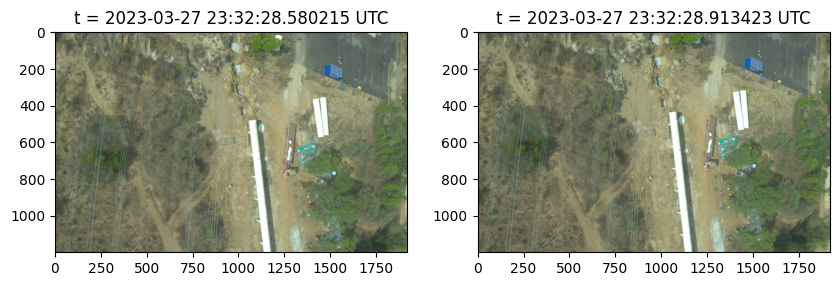

In [109]:
rn_ent = random.randint(0, len(sample_dir) - 2)
print('Random-ENT: ', rn_ent)

# target_size = (256, 256)

print(f't = {rev_flight_obj[sample_dir[rn_ent]]} --> {sample_dir[rn_ent]} UTC , t = {rev_flight_obj[sample_dir[rn_ent + 1]]} --> {sample_dir[rn_ent + 1]} UTC')
sample_first_path, sample_second_path = os.path.join(sample_dataset_path, sample_dir[rn_ent]), os.path.join(sample_dataset_path, sample_dir[rn_ent + 1])
sample_first_frame, sample_second_frame = Image.open(sample_first_path), Image.open(sample_second_path)
sample_first_frame, sample_second_frame = np.asarray(sample_first_frame), np.asarray(sample_second_frame)
# sample_first_frame, sample_second_frame = cv2.resize(sample_first_frame, target_size), cv2.resize(sample_second_frame, target_size)

print(sample_first_frame.shape, sample_second_frame.shape)
E243
fig, axs = plt.subplots(1, 2, figsize = (10, 10))

axs[0].imshow(sample_first_frame)
axs[0].set_title(f't = {rev_flight_obj[sample_dir[rn_ent]]} UTC')

axs[1].imshow(sample_second_frame)
axs[1].set_title(f't = {rev_flight_obj[sample_dir[rn_ent + 1]]} UTC')

plt.show()

### Optical-Stitching

In [110]:
resized_frames = np.array([cv2.resize(cv2.imread(os.path.join(sample_dataset_path, nm)), image_size) for nm in sample_dir])
print(resized_frames.shape)

(100, 1200, 1920, 3)


Num-Frames:  100


Stitching frames: 100%|██████████| 100/100 [04:00<00:00,  2.40s/frame]


Execution-time (UNIX):  240.02910256385803


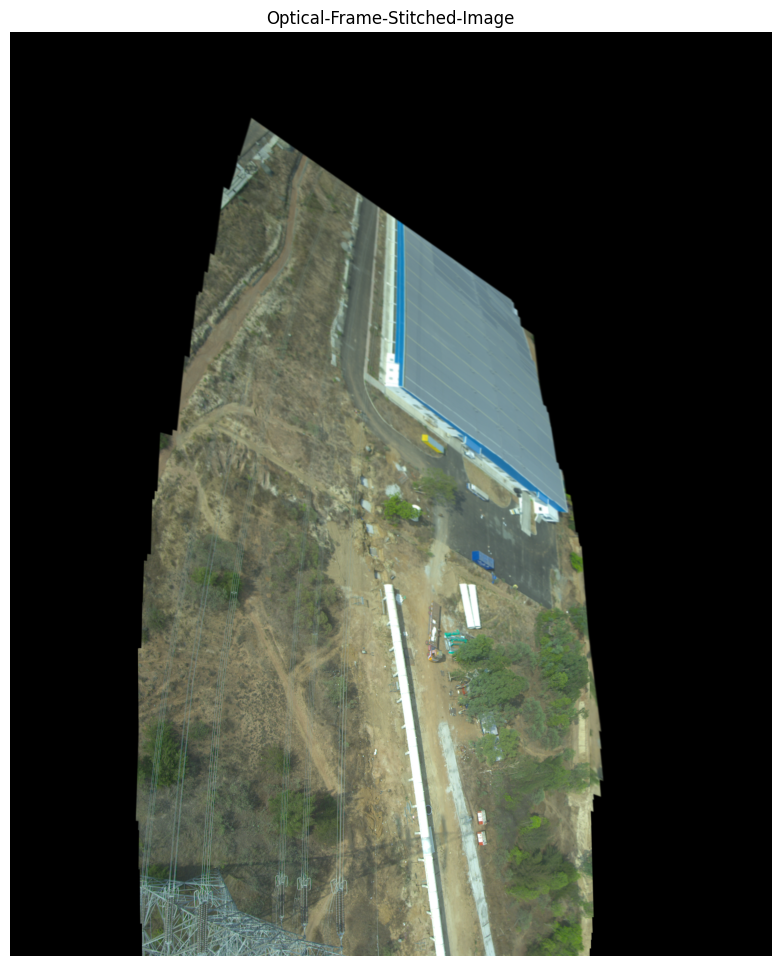

In [111]:
import time

num_frames = len(resized_frames)
# num_frames = 5

print('Num-Frames: ', num_frames)
detector = "SIFT"
matcher = "BF"
threshold = 0.75
trajMap = np.zeros((*image_size, 3), dtype=np.uint8)
out_pose_file = 'traj_est.txt'


ft = time.time()
for i in tqdm((range(num_frames)), desc="Stitching frames", unit="frame"):

    if i == 0:
        result_img = resized_frames[i]
        curr_R = np.eye(3)
        curr_t = np.array([0, 0, 0]).astype('float64')

    else:
        Image1 = result_img
        Image2 = resized_frames[i]

        # Checking if images read
        if Image1 is None or Image2 is None:
            print("\nImages not read properly or does not exist.\n")
            exit(0)

        # Calling function for stitching images.

        eae = EAE(Image2, Image1)
        _, t, euler_angle_rad, _ = eae.run(is_store = True)
        euler_angle = [euler_angle_rad['roll'], euler_angle_rad['pitch'], euler_angle_rad['yaw']]
        R = euler_angles_to_rotation_matrix(euler_angle)
        result_img = stitch_frames(Image2, Image1, curr_R, curr_t)

        ''' For Comparison '''

        # stitcher = Stitcher(Image2, Image1, detector, matcher, threshold)
        # _, R_temp, _ = stitcher.stitch_frames(curr_R, curr_t, fx, cx, cy)

        # # print('R: ', R)
        # # print()
        # # print('R_temp: ', R_temp)
        # print('Diff: ', abs(R - R_temp))
        # print()

        if i == 1:
          curr_R = R
          curr_t = t

        else:
          curr_R = np.matmul(prev_R, R)
          curr_t = (np.matmul(prev_R, t)) + (prev_t)

        prev_R = curr_R
        prev_t = abs(curr_t)

    pass

lt = time.time()

print('Execution-time (UNIX): ', (lt - ft))

fig, axs = plt.subplots(1, 1, figsize = (12, 12))

result_img = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)
# result_img = cv2.resize(result_img, image_size)

axs.imshow(result_img)
axs.set_title('Optical-Frame-Stitched-Image')

plt.axis('off')
plt.show()

#### Different-Display

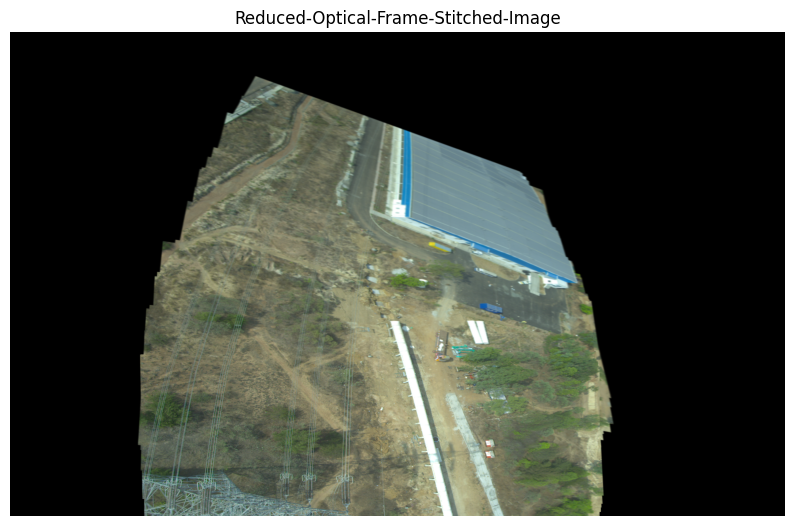

In [112]:
image_size = (1920, 1200)

fig, axs = plt.subplots(1, 1, figsize = (10, 10))

axs.imshow(cv2.resize(result_img, image_size))
axs.set_title('Reduced-Optical-Frame-Stitched-Image')

plt.axis('off')
plt.show()

In [113]:
import tifffile

tifffile.imwrite(f'/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/stitched_img_{sample_parent_dir[choice]}_for_{num_frames}_frames.tiff', result_img)

### INS Data Retrival and Frame Matching
There's a precision problem (in Jetson-Time) when trying to load the CSV file

In [142]:
flight_num = 'E243'

In [144]:
combine_ins_path_all = f"/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/INS_Data/{flight_num}/ins/combine_ins_E243_1679939672_time.csv"
combine_ins_path_time = f"/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/INS_Data/{flight_num}/ins/ins_E243_1679939672_time.csv"

dtypes = {' Jetson Time': np.float64}
df_ins_data_time = pd.read_csv(combine_ins_path_time, float_precision='high', dtype=dtypes)
df_ins_data_all = pd.read_csv(combine_ins_path_all)

display(df_ins_data_time.head(3))
display(df_ins_data_all.head(3))
df_ins_data_time[' Jetson Time'][0]

,Packet Count,Jetson Time
0,0,1.679940e+09
1,1,1.679940e+09
2,2,1.679940e+09


,Packet Count,UTC Time,Acc_SensorX,Acc_SensorY,Acc_SensorZ,Gyr_SensorX,Gyr_SensorY,Gyr_SensorZ,Mag_SensorX,Mag_SensorY,...,RawAccZ,SampleTimeFine,LatitudeRaw,LongitudeRaw,Height,HeightMSL,nanoseconds,Pressure,Packet Countextra,Jetson Time
0,0,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,570954,NaN,NaN,NaN,NaN,NaN,NaN,0,1.679940e+09
1,1,20,-0.40,0.31,9.79,-0.01,0.0,0.0,-0.62,-0.29,...,NaN,571054,NaN,NaN,NaN,NaN,NaN,NaN,1,1.679940e+09
2,2,20,-0.41,0.31,9.80,-0.01,0.0,0.0,-0.62,-0.29,...,NaN,571154,NaN,NaN,NaN,NaN,NaN,100764.0,2,1.679940e+09


1679939672.5391116

In [150]:
j_col = df_ins_data_time.columns[-1]
p_col = df_ins_data_time.columns[0]

print('Columns of Interest: ', j_col, ', ', p_col)

Columns of Interest:   Jetson Time ,  Packet Count


In [151]:
ins_jetson = list(df_ins_data_time[j_col].dropna())
ins_jetson = [str(time).split('.')[0] + '_' + '0' for time in ins_jetson]
utc_ins_jetson = list(map(jetson_timestamp_to_utc, ins_jetson))
ins_flight_obj = {}
for unix_time, utc_time in zip(ins_jetson, utc_ins_jetson):
  ins_flight_obj[utc_time] = unix_time

### Euler Angle Estimation

In [152]:
print(type(rev_flight_obj))
df_data = [df_ins_data_time, df_ins_data_all]

<class 'dict'>


In [153]:
## Rotation Order - X, Y, Z (Roll, Pitch, Yaw)
sample_timestamp = sample_dir[0]
print(sample_timestamp)
ins_euler_angle = closest_ea(sample_timestamp, rev_flight_obj, df_data, want_prev=False)

## ( 0-th - 1 ) frame
prev_ins_euler_angle = closest_ea(sample_timestamp, rev_flight_obj, df_data, want_prev=True)

print('prev_ins_euler_angle: ', prev_ins_euler_angle)

img_E243_477142597593_1679940124_584049474.tiff
prev_ins_euler_angle:  [-2.77, 9.99, -96.91]


In [154]:
pred_ins_euler_angle = [(prev_ea + delta_ea) for delta_ea, prev_ea in zip(list(euler_angle_rad.values()), prev_ins_euler_angle)]

print('OPTICAL-FRAME-EST. -> ')
print(f'ROLL (in rad) : {pred_ins_euler_angle[0]:.2f}, PITCH (in rad) : {pred_ins_euler_angle[1]:.2f}, YAW (in rad) : {pred_ins_euler_angle[-1]:.2f}')
print()
print('INS (IMU) Value -> ')
print(f'ROLL (in rad) : {ins_euler_angle[0]}, PITCH (in rad) : {ins_euler_angle[1]}, YAW (in rad) : {ins_euler_angle[-1]}')

OPTICAL-FRAME-EST. -> 
ROLL (in rad) : -2.77, PITCH (in rad) : 9.99, YAW (in rad) : -96.92

INS (IMU) Value -> 
ROLL (in rad) : -2.72, PITCH (in rad) : 10.07, YAW (in rad) : -96.89


### (Consecutive Flight-Parameter Estimation)
We will estimate consecutive 5-frame flight-parameters and compare with INS sensor parameter values

In [155]:
init_timestamp = sample_dir[0]
init_euler_angle = closest_ea(init_timestamp, rev_flight_obj, df_data, want_prev = False)

print('Init-Flight-Parameters: ', init_euler_angle)

Init-Flight-Parameters:  [-2.72, 10.07, -96.89]


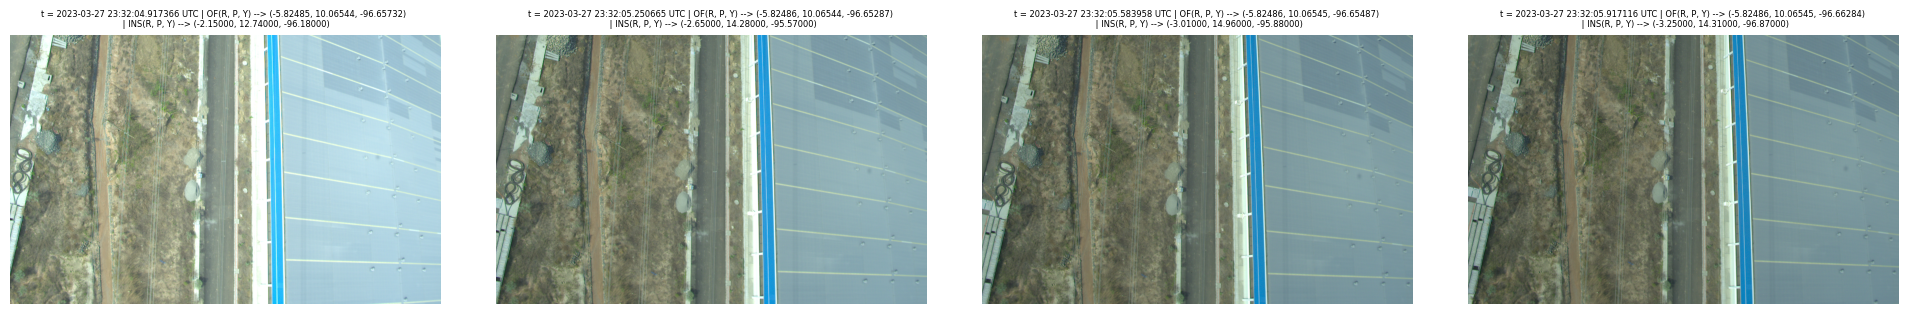

Execution-Time (UNIX):  2.796786069869995


In [156]:
import time

num_frames = 4#5
fig, axs = plt.subplots(1, num_frames, figsize = (20, 20))

ini_frame_path = os.path.join(sample_dataset_path, sample_dir[0])
ini_frame = np.asarray(Image.open(ini_frame_path))

ft = time.time()
for i in range(num_frames):

  next_frame_path = os.path.join(sample_dataset_path, sample_dir[i + 1])
  next_frame = np.asarray(Image.open(next_frame_path))

  eae = EAE(next_frame, ini_frame)
  euler_angle_rad, euler_angle_deg = eae.run()

  pred_ins_euler_angle = [(prev_ea + delta_ea) for delta_ea, prev_ea in zip(list(euler_angle_rad.values()), init_euler_angle)]
  ins_euler_angle = closest_ea(sample_dir[i + 1], rev_flight_obj, df_data, want_prev = False)

  axs[i].imshow(next_frame)
  axs[i].set_title(f't = {rev_flight_obj[sample_dir[i+1]]} UTC | OF(R, P, Y) --> ({pred_ins_euler_angle[0]:.5f}, {pred_ins_euler_angle[1]:.5f}, {pred_ins_euler_angle[-1]:.5f}) \n | INS(R, P, Y) --> ({ins_euler_angle[0]:.5f}, {ins_euler_angle[1]:.5f}, {ins_euler_angle[-1]:.5f})', fontsize = 6)
  axs[i].axis('off')

  ini_frame = next_frame
  init_euler_angle = pred_ins_euler_angle

plt.tight_layout(pad = 4)
plt.show()

lt = time.time()

print('Execution-Time (UNIX): ', (lt - ft))

In [165]:
import numpy as np

sensor_width = 29.3  # mm
sensor_height = 29  # mm

image_width = 1920  # in pixels
image_height = 1200  # in pixels

pixel_size_x = sensor_width / image_width
pixel_size_y = sensor_height / image_height

scale_factor_x = pixel_size_x / fx  # m/pixel
scale_factor_y = pixel_size_y / fy  # m/pixel

scale_factor = (scale_factor_x + scale_factor_y) / 2

print('Scale-Factor: ', scale_factor)

Scale-Factor:  2.7423491862997134e-05


### Flight-Parameter Data-Saving (CSV) | [Unix-Timestamp, Roll, Pitch, Yaw, Lat, Lon, Alt]

In [168]:
num_frames = len(sample_dir)
print('No. of frames:', num_frames)

No. of frames: 100


In [169]:
timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in sample_dir]
utc_timestamps_list = list(map(jetson_timestamp_to_utc, timestamps_list))

print(utc_timestamps_list)

flight_obj = {}
rev_flight_obj = {}

for time, path in zip(utc_timestamps_list, sample_dir):
  flight_obj[time] = path
  rev_flight_obj[path] = time

unix_timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in sample_dir]
unix_timestamps_list = list(map(get_unix_timestamps, timestamps_list))
print('Timestamps: ', unix_timestamps_list[:3], ', Timestamps-size: ', len(unix_timestamps_list))

['2023-03-27 23:32:04.584049', '2023-03-27 23:32:04.917366', '2023-03-27 23:32:05.250665', '2023-03-27 23:32:05.583958', '2023-03-27 23:32:05.917116', '2023-03-27 23:32:06.250468', '2023-03-27 23:32:06.583809', '2023-03-27 23:32:06.916641', '2023-03-27 23:32:07.250345', '2023-03-27 23:32:07.583614', '2023-03-27 23:32:07.916462', '2023-03-27 23:32:08.249837', '2023-03-27 23:32:08.583091', '2023-03-27 23:32:08.916372', '2023-03-27 23:32:09.249740', '2023-03-27 23:32:09.582987', '2023-03-27 23:32:09.916318', '2023-03-27 23:32:10.249517', '2023-03-27 23:32:10.582795', '2023-03-27 23:32:10.916010', '2023-03-27 23:32:11.249388', '2023-03-27 23:32:11.582589', '2023-03-27 23:32:11.916150', '2023-03-27 23:32:12.249129', '2023-03-27 23:32:12.582574', '2023-03-27 23:32:12.915820', '2023-03-27 23:32:13.249027', '2023-03-27 23:32:13.582414', '2023-03-27 23:32:13.915662', '2023-03-27 23:32:14.248922', '2023-03-27 23:32:14.582109', '2023-03-27 23:32:14.915542', '2023-03-27 23:32:15.248745', '2023-03-

In [170]:
import time

initial_frame_timestamp = sample_dir[0]
print('initial_frame_timestamp: ', initial_frame_timestamp)

# ref_coordinates = [12.9, 80.2, 6.7]
ini_ea = closest_ea(initial_frame_timestamp, rev_flight_obj, df_data)
ini_coordinates = closest_t(initial_frame_timestamp, rev_flight_obj, df_data)

ini_frame_path = os.path.join(sample_dataset_path, sample_dir[0])
ini_frame = np.asarray(Image.open(ini_frame_path))

df_OF_cols = ['Timestamps', 'Roll_N', 'Pitch_E', 'Yaw_U', 'Latitude', 'Longitude', 'Altitude']
roll_list, pitch_list, yaw_list, lat_list, lon_list, alt_list = [], [], [], [], [], []

ft = time.time()

for i in tqdm(range(num_frames), desc="Processing frames", unit="frame"):

  roll_list.append(ini_ea[0])
  pitch_list.append(ini_ea[1])
  yaw_list.append(ini_ea[-1])
  lat_list.append(ini_coordinates[0])
  lon_list.append(ini_coordinates[1])
  alt_list.append(ini_coordinates[-1])

  if (i + 1) >= num_frames:
    break

  pass

  next_frame_path = os.path.join(sample_dataset_path, sample_dir[i + 1])
  next_frame = np.asarray(Image.open(next_frame_path))

  eae = EAE(next_frame, ini_frame)
  one_frame_R, one_frame_t, euler_angle_rad, _ = eae.run(is_store = True)

  pred_ins_euler_angle = [(prev_ea + delta_ea) for delta_ea, prev_ea in zip(list(euler_angle_rad.values()), ini_ea)]
  lat, lon, alt = trans_vec_to_lla(one_frame_t, one_frame_R, scale_factor, ini_ea, ini_coordinates)

  ini_frame = next_frame
  ini_ea = pred_ins_euler_angle
  ini_coordinates = [lat, lon, alt]


df_of = pd.DataFrame(columns = df_OF_cols)

data = {
    'Timestamps': unix_timestamps_list,
    'Roll_N': roll_list,
    'Pitch_E': pitch_list,
    'Yaw_U': yaw_list,
    'Latitude': lat_list,
    'Longitude': lon_list,
    'Altitude': alt_list
}


df_of = pd.DataFrame(data)
display(df_of.head(3))

lt = time.time()

print('Execution-time (UNIX): ', (lt - ft))

initial_frame_timestamp:  img_E243_477142597593_1679940124_584049474.tiff


Processing frames:  99%|█████████▉| 99/100 [00:52<00:00,  1.88frame/s]


,Timestamps,Roll_N,Pitch_E,Yaw_U,Latitude,Longitude,Altitude
0,1.679940e+09,-2.720000,10.070000,-96.890000,12.791947,80.189087,15.260000
1,1.679940e+09,-5.824847,10.065439,-96.657323,12.791947,80.189087,15.259984
2,1.679940e+09,-5.824857,10.065443,-96.652867,12.791947,80.189087,15.259964


Execution-time (UNIX):  52.5594596862793


In [ ]:
df_of.to_csv('optical_frame_parameters_strip_E240_1679940007.csv', index=False)

### Euler Angle Trend Comparision (Optical Frames and INS)

In [171]:
ins_ea = [closest_ea(timestamp, rev_flight_obj, df_data) for timestamp in sample_dir]
ins_unix_timestamps_list = [closest_ea(timestamp, rev_flight_obj, df_data, want_timestamp=True)[-1] for timestamp in sample_dir]

pprint(ins_ea[:10])
print()
pprint(ins_unix_timestamps_list[:10])
print()
print('No. of Frames: ', len(ins_unix_timestamps_list))

ins_roll_N = [r for r, p, y in ins_ea]
ins_pitch_E = [p for r, p, y in ins_ea]
ins_yaw_U = [y for r, p, y in ins_ea]

[[-2.72, 10.07, -96.89],
 [-2.15, 12.74, -96.18],
 [-2.65, 14.28, -95.57],
 [-3.01, 14.96, -95.88],
 [-3.25, 14.31, -96.87],
 [-2.16, 12.36, -98.02],
 [-0.8, 11.09, -99.72],
 [-1.01, 9.37, -100.68],
 [-2.06, 6.82, -100.54],
 [-2.61, 5.78, -99.29]]

[1679940124.5939848,
 1679940124.9058366,
 1679940125.24573,
 1679940125.5746193,
 1679940125.906144,
 1679940126.245514,
 1679940126.5745668,
 1679940126.9052818,
 1679940127.245002,
 1679940127.5746477]

No. of Frames:  100


In [172]:
of_pitch_E = list(df_of.Pitch_E)
of_roll_N = list(df_of.Roll_N)
of_yaw_U = list(df_of.Yaw_U)

print('OF-pitch-E: ', of_pitch_E[:10])
print('OF-roll-N: ', of_roll_N[:10])
print('OF-yaw-U: ', of_yaw_U[:10])

OF-pitch-E:  [10.07, 10.065439371760185, 10.06544287020875, 10.065447772866225, 10.065447133328542, 10.051915967103698, 10.03206229046159, 10.032063627388524, 10.032068525908324, 10.032073757007602]
OF-roll-N:  [-2.72, -5.824847003839356, -5.824857053979929, -5.824861743743428, -5.824858927182655, -2.7118796675314703, 0.40507138525641384, 0.40508247627955035, 0.4050918297368612, 0.4050918415046016]
OF-yaw-U:  [-96.89, -96.65732317059134, -96.65286651215474, -96.65486952654761, -96.66284158319797, -97.53203252906395, -98.88679457649768, -98.89217720520162, -98.87408578410975, -98.84514382418135]


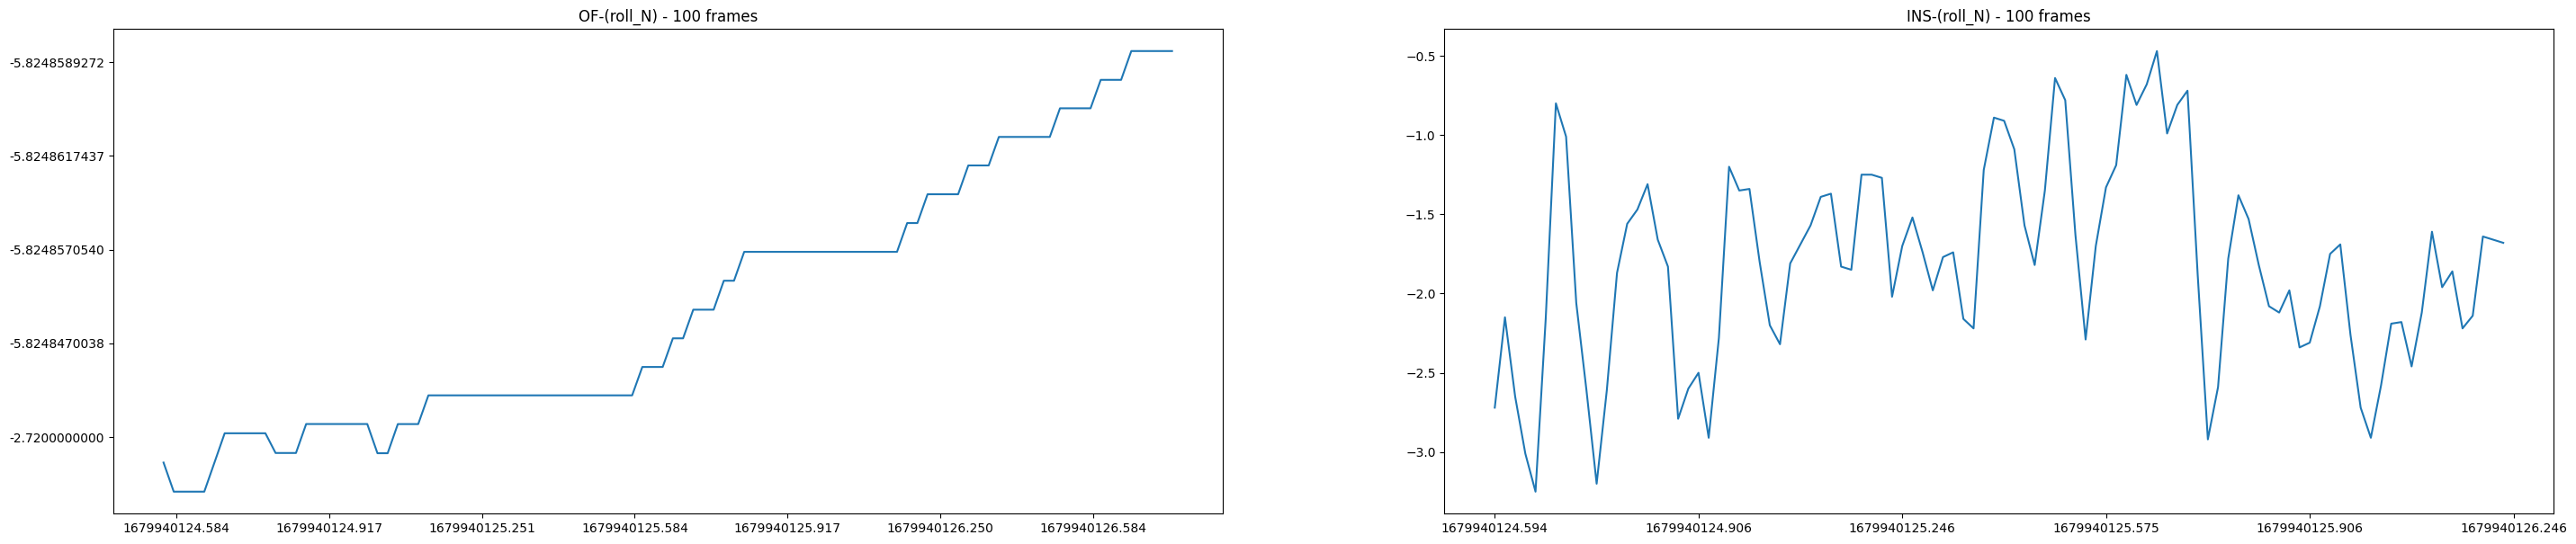

Mean:  13.952749428209772 ,  -1.8129999999999997


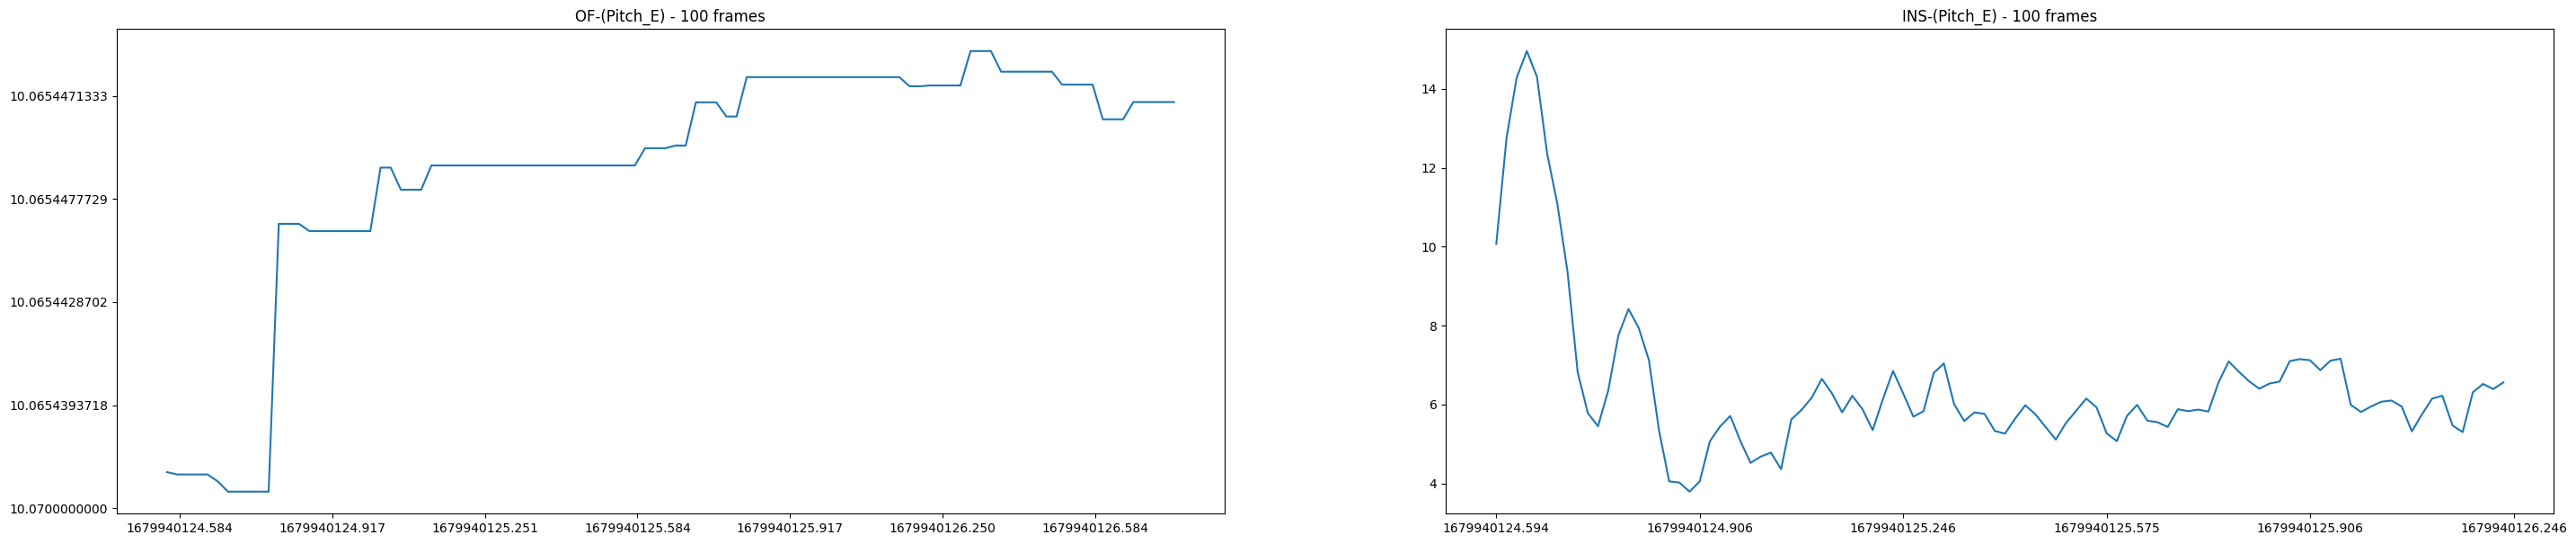

Mean:  10.660086733293754 ,  6.462099999999998


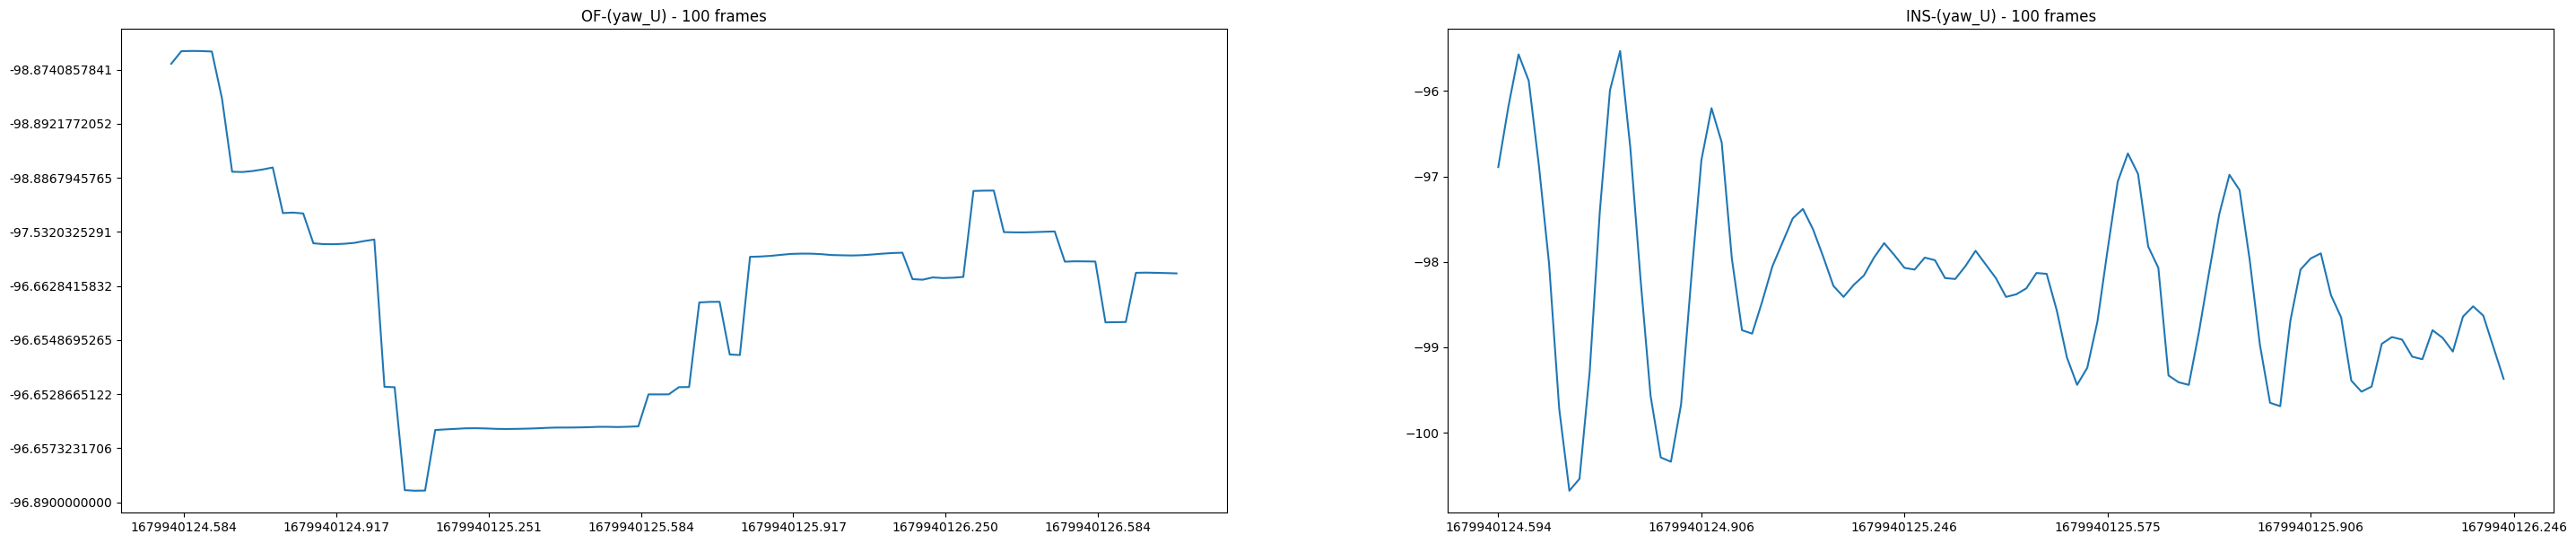

Mean:  -101.15713714991384 ,  -101.15713714991384


In [181]:
fig, axs = plt.subplots(1, 2, figsize = (35, 7))

xtick_labels_of = [f"{value:.3f}" for value in [0] + unix_timestamps_list]
xtick_labels_ins = [f"{value:.3f}" for value in [0] + ins_unix_timestamps_list]

ytick_labels = [f"{value:.10f}" for value in [0] + of_roll_N]  # Format with 15 decimal places
axs[0].plot(unix_timestamps_list, of_roll_N)
axs[0].set_yticklabels(ytick_labels)
axs[0].set_xticklabels(xtick_labels_of)
axs[0].set_title(f'OF-(roll_N) - {num_frames} frames')

axs[1].plot(ins_roll_N)
axs[1].set_title(f'INS-(roll_N) - {num_frames} frames')
axs[1].set_xticklabels(xtick_labels_ins)

plt.show()

print('Mean: ', np.mean(np.array(of_roll_N)), ', ', np.mean(np.array(ins_roll_N)))

fig, axs = plt.subplots(1, 2, figsize = (35, 7))

ytick_labels = [f"{value:.10f}" for value in [0] + of_pitch_E]  # Format with 15 decimal places

axs[0].plot(unix_timestamps_list, of_pitch_E)
axs[0].set_yticklabels(ytick_labels)
axs[0].set_xticklabels(xtick_labels_of)
axs[0].set_title(f'OF-(Pitch_E) - {num_frames} frames')

axs[1].plot(ins_pitch_E)
axs[1].set_title(f'INS-(Pitch_E) - {num_frames} frames')
axs[1].set_xticklabels(xtick_labels_ins)

plt.show()

print('Mean: ', np.mean(np.array(of_pitch_E)), ', ', np.mean(np.array(ins_pitch_E)))

fig, axs = plt.subplots(1, 2, figsize = (35, 7))

ytick_labels = [f"{value:.10f}" for value in [0] + of_yaw_U]  # Format with 15 decimal places
axs[0].plot(unix_timestamps_list, of_yaw_U)
axs[0].set_xticklabels(xtick_labels_of)
axs[0].set_yticklabels(ytick_labels)
axs[0].set_title(f'OF-(yaw_U) - {num_frames} frames')

axs[1].plot(ins_yaw_U)
axs[1].set_title(f'INS-(yaw_U) - {num_frames} frames')
axs[1].set_xticklabels(xtick_labels_ins)

plt.show()

print('Mean: ', np.mean(np.array(of_yaw_U)), ', ', np.mean(np.array(of_yaw_U)))


In [177]:
max(of_roll_N)

41.195888691853895